In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [9]:
df = pd.read_csv(r"C:\Users\Dell\gitproject\Energy_Demand_Forecasting\data\processed\Energy Consumption Cleaned.csv", parse_dates=['Date'])

In [11]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [13]:
df.head()

,States,Regions,latitude,longitude,Date,Energy Consumption
0,Punjab,NR,31.519974,75.980003,2019-02-01,119.9
1,Haryana,NR,28.450006,77.019991,2019-02-01,130.3
2,Rajasthan,NR,26.449999,74.639981,2019-02-01,234.1
3,Delhi,NR,28.669993,77.230004,2019-02-01,85.8
4,UP,NR,27.599981,78.050006,2019-02-01,313.9


In [17]:
print("Number of duplicates:", df.duplicated(subset=['Date', 'States']).sum())


Number of duplicates: 153


In [19]:
df_agg = df.groupby(['Date', 'States'], as_index=False)['Energy Consumption'].mean()


In [21]:
df_wide = df_agg.pivot(index='Date', columns='States', values='Energy Consumption')


In [23]:
print(df_wide.head())


States      Andhra Pradesh  Arunachal Pradesh  Assam  Bihar  Chandigarh  \
Date                                                                      
2019-01-07           164.3                2.3   34.2  104.7         4.8   
2019-01-08           197.0                2.4   32.7  106.4         5.5   
2019-01-09           153.8                2.3   36.1   96.1         5.4   
2019-01-10           155.4                1.9   30.2   88.1         3.9   
2019-01-11           154.9                1.5   19.2   82.8         2.4   

States      Chhattisgarh   DNH  Delhi   Goa  Gujarat  ...  Pondy  Punjab  \
Date                                                  ...                  
2019-01-07          94.5  18.9  103.8  11.7    300.2  ...    7.5   163.9   
2019-01-08          87.9  17.8   99.3  11.5    316.1  ...    9.2   206.1   
2019-01-09          95.8  18.4  113.9  11.5    320.2  ...    7.4   224.0   
2019-01-10          78.2  18.2   80.7  10.3    362.1  ...    6.9   118.9   
2019-01-11        

In [39]:
scalers = {}
scaled_data = pd.DataFrame(index=df_wide.index)

for state in df_wide.columns:
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(df_wide[state].values.reshape(-1, 1))
    scaled_data[state] = scaled_values.flatten()
    scalers[state] = scaler

scaled_data.head()


,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chandigarh,Chhattisgarh,DNH,Delhi,Goa,Gujarat,...,Pondy,Punjab,Rajasthan,Sikkim,Tamil Nadu,Telangana,Tripura,UP,Uttarakhand,West Bengal
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-07,0.452349,0.785714,0.852713,0.785623,0.500000,0.770161,0.967033,0.588794,0.705128,0.517506,...,0.614035,0.441984,0.436121,0.24,0.508544,0.694511,0.595238,0.675789,0.469780,0.682313
2019-01-08,0.891275,0.857143,0.794574,0.807445,0.634615,0.681452,0.906593,0.546059,0.679487,0.593765,...,0.912281,0.615006,0.684669,0.36,0.933412,0.322196,0.785714,0.692281,0.708791,0.850340
2019-01-09,0.311409,0.785714,0.926357,0.675225,0.615385,0.787634,0.939560,0.684710,0.679487,0.613429,...,0.596491,0.688397,0.782230,0.32,0.479081,0.291169,0.809524,0.574737,0.642857,0.825170
2019-01-10,0.332886,0.500000,0.697674,0.572529,0.326923,0.551075,0.928571,0.369421,0.525641,0.814388,...,0.508772,0.257483,0.595819,0.24,0.403654,0.136038,0.523810,0.455088,0.497253,0.770748
2019-01-11,0.326174,0.214286,0.271318,0.504493,0.038462,0.551075,0.049451,0.100665,0.115385,0.274341,...,0.087719,0.090611,0.311847,0.24,0.191514,0.296738,0.166667,0.295439,0.090659,0.536054


In [29]:
def create_sequences(data, seq_length=30):
    """
    Prepare input sequences and corresponding targets for LSTM.
    
    Parameters:
        data (1D numpy array): Scaled time series data.
        seq_length (int): Number of time steps in input sequence.
    
    Returns:
        X (numpy array): Input sequences (samples, seq_length).
        y (numpy array): Target values (samples, ).
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


## Train and Evaluate LSTM Model for Each State
- Using past 30 days to predict next day
- 80% train, 20% test split
- Metrics: RMSE, MAE, R²


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step


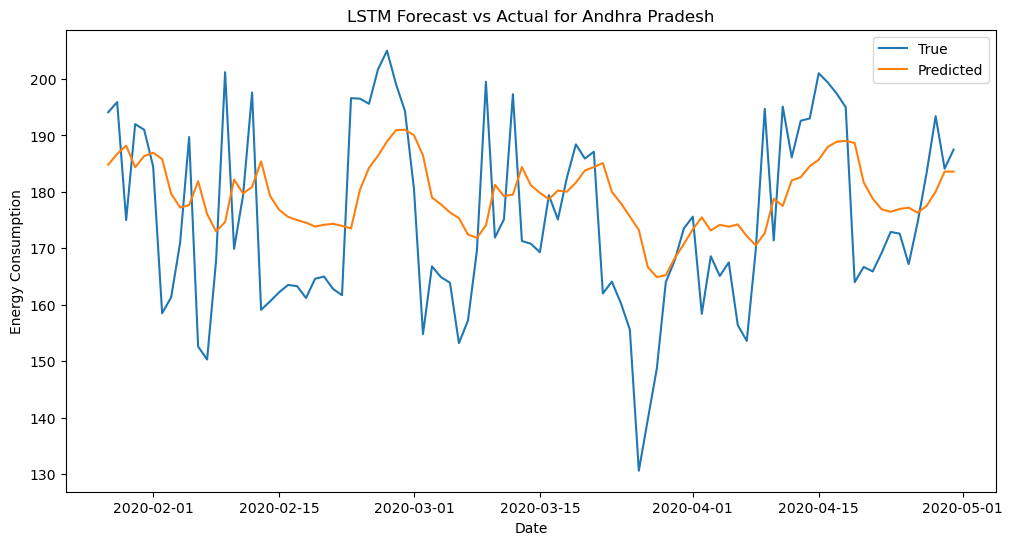

C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002721B7D9D00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 783ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 621ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step


In [42]:
seq_length = 30
train_ratio = 0.8
train_size = int(len(df_wide) * train_ratio)

metrics_all_states = {}

for state in df_wide.columns:
    data = scaled_data[state].values
    X, y = create_sequences(data, seq_length)
    
    X_train = X[:train_size - seq_length]
    y_train = y[:train_size - seq_length]
    X_test = X[train_size - seq_length:]
    y_test = y[train_size - seq_length:]
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(seq_length, 1)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)
    
    y_pred = model.predict(X_test).flatten()
    
    scaler = scalers[state]
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    
    metrics_all_states[state] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    
    if state == df_wide.columns[0]:
        plt.figure(figsize=(12, 6))
        plt.plot(df_wide.index[-len(y_test_inv):], y_test_inv, label='True')
        plt.plot(df_wide.index[-len(y_test_inv):], y_pred_inv, label='Predicted')
        plt.title(f'LSTM Forecast vs Actual for {state}')
        plt.xlabel('Date')
        plt.ylabel('Energy Consumption')
        plt.legend()
        plt.show()


## Display Metrics for All States


In [47]:
lstm_metrics_df = pd.DataFrame(metrics_all_states).T
lstm_metrics_df


,RMSE,MAE,R2
Andhra Pradesh,14.593984,12.057355,0.168728
Arunachal Pradesh,0.228562,0.156933,0.033201
Assam,4.333974,3.343060,0.036367
Bihar,14.880132,11.511620,0.012613
Chandigarh,1.245016,0.938731,0.081713
Chhattisgarh,8.645534,7.293230,0.100069
DNH,3.894865,2.485136,0.257692
Delhi,27.507230,21.548238,0.102166
Goa,1.436188,1.135727,0.200496
Gujarat,34.128226,25.727188,0.265300


In [49]:
lstm_metrics_df.to_csv("lstm_metrics_summary.csv", index=True)